# Welcome to our project !
## Our project is about Covid-19 in israel
### And the connection between high/low social-econimic rated cities and the Covid-19





### 1) At first we will import all the libraries we will use in the project


In [26]:
import requests 
import json
import pandas as pd 
import bs4
from bs4 import BeautifulSoup  
import sklearn
from sklearn import preprocessing, linear_model, model_selection, tree
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import  f1_score, plot_confusion_matrix, make_scorer
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

Thank_You = Image.open(r"End.png") 


#  2) Now we will start our Wikipedia crawling
### We need data like - Population and Social-economic rating

In [27]:
wiki_city=[] 
wiki_population = [] 
wiki_social_economic=[] 
Wiki = "https://he.m.wikipedia.org/wiki/ערים_בישראל"
html = requests.get(Wiki)
soup= BeautifulSoup(html.content,"html.parser")
table = soup("table",attrs={"class":"toccolours sortable"})[0]
for rows in table("tr"):
    cells=rows("td")
    if(len(cells)<13):
        continue
    wiki_city.append(cells[1].get_text().strip())
    wiki_population.append(cells[3].get_text().strip())
    wiki_social_economic.append(int(cells[11].get_text().strip()))
for i in range(len(wiki_population)):
    if len(wiki_population[i]) == 7:
        string= wiki_population[i]
        string = string[:3] + string[4:]
        wiki_population[i]= int(string)
    else:
        string= wiki_population[i]
        string = string[:2] + string[3:]
        wiki_population[i]= int(string)
Wiki_df = pd.DataFrame({"Social-Economy":wiki_social_economic,"Population":wiki_population,"City":wiki_city}) 
Wiki_df

,Social-Economy,Population,City
0,3,951702,ירושלים
1,8,465728,תל אביב-יפו
2,7,285041,חיפה
3,7,255879,ראשון לציון
4,7,249994,פתח תקווה
...,...,...,...
72,5,22442,קריית שמונה
73,5,22146,מעלות- תרשיחא
74,6,20485,אריאל
75,5,19392,אור עקיבא


#### We finished with the crawling 
### 3) now we about to pull more data from an API
### We going to pull all the "Covid-19" data from the Israeli Government site.

In [28]:

City_Name=[]
Date=[]
Cumulative_verified_cases=[]
New_Daily_Verified=[]
Cumulated_recovered=[]
New_Daily_recovered=[]
Cumulated_deaths=[]
New_Daily_deaths=[]
Cumulated_number_of_tests=[]
New_Daily_tests=[]
Social_Economic_Binary = []
Social_Economic = []
Population = []
Cities = [  'חולון' , 'רעננה' , 'בני ברק', 'באר שבע','נתיבות', 'רמת גן', 'רחובות','אשקלון','מודיעין עילית', 'רהט', 'צפת','טייבה','חיפה','כפר סבא','ביתר עילית','פתח תקווה','הוד השרון', 'אשדוד', 'בית שמש', 'לוד', 'רמלה', 'נצרת']

url = "https://data.gov.il/api/3/action/datastore_search?resource_id=8a21d39d-91e3-40db-aca1-f73f7ab1df69&limit=130000"  
r= requests.get(url)
resDict = r.json()
for rec in resDict['result']['records']:
    if(rec['City_Name'] in Cities):
        City_Name.append(rec['City_Name'])
        string = rec['Date']
        string = string[8:] +"/" +string[5:7] + "/" + string[:4] 
        Date.append(string)
        if rec['Cumulative_verified_cases'] == '<15':
            Cumulative_verified_cases.append(int(8))
        else:
            Cumulative_verified_cases.append(int(rec['Cumulative_verified_cases']))
        if rec["Cumulated_deaths"]  == '<15':
            Cumulated_deaths.append(int(8))
        else:
            Cumulated_deaths.append(int(rec["Cumulated_deaths"]))
        if rec["Cumulated_recovered"] == '<15':
            Cumulated_recovered.append(int(8))
        else:    
            Cumulated_recovered.append(int(rec["Cumulated_recovered"]))
        if  rec["Cumulated_number_of_tests"]=="<15":
            Cumulated_number_of_tests.append(int(8))
        else:
            Cumulated_number_of_tests.append(int(rec["Cumulated_number_of_tests"]))
        for pop in range(len(wiki_city)):
            if (rec['City_Name'] == wiki_city[pop]):
                if wiki_social_economic[pop] > 4:
                    Social_Economic_Binary.append(1)
                else:
                    Social_Economic_Binary.append(0)
                Population.append(wiki_population[pop])
                Social_Economic.append(wiki_social_economic[pop])
                        
                    
        
New_Daily_Verified.append(int(0))
New_Daily_recovered.append(int(0))
New_Daily_deaths.append(int(0))
New_Daily_tests.append(int(0))
for i in range(len(Cumulative_verified_cases)-1):
    if City_Name[i+1] != City_Name[i]:     
        New_Daily_Verified.append(int(0))
        New_Daily_recovered.append(int(0))
        New_Daily_deaths.append(int(0))
        New_Daily_tests.append(int(0))
    else:
        New_Daily_Verified.append(Cumulative_verified_cases[i+1] - (Cumulative_verified_cases[i]))
        New_Daily_recovered.append(Cumulated_recovered[i+1]-Cumulated_recovered[i])
        New_Daily_deaths.append(Cumulated_deaths[i+1]-Cumulated_deaths[i])
        New_Daily_tests.append(Cumulated_number_of_tests[i+1]-Cumulated_number_of_tests[i])

for i in range(len(Cumulated_deaths)):
    if(New_Daily_Verified[i]< 0 ):
        New_Daily_Verified[i]=0
    if (New_Daily_recovered[i]<0):
        New_Daily_recovered[i]= 0
    if (New_Daily_deaths[i]<0):
         New_Daily_deaths[i]=0
    if(New_Daily_tests[i]<0):
        New_Daily_tests[i]=0

        
df=pd.DataFrame({"City Name":City_Name,"Date":Date,"Population":Population,"Social Economic Rate":Social_Economic_Binary,"Cumulative verified cases":Cumulative_verified_cases,"New Daily verified":New_Daily_Verified,"Cumulated recovered":Cumulated_recovered,"Daily Recoverd":New_Daily_recovered,"Cumulated number of tests":Cumulated_number_of_tests,"Daily tests":New_Daily_tests,"Cumulated deaths":Cumulated_deaths,"Daily deaths":New_Daily_deaths})
df

,City Name,Date,Population,Social Economic Rate,Cumulative verified cases,New Daily verified,Cumulated recovered,Daily Recoverd,Cumulated number of tests,Daily tests,Cumulated deaths,Daily deaths
0,אשדוד,14/03/2020,226252,1,0,0,0,0,34,0,0,0
1,אשדוד,15/03/2020,226252,1,8,8,0,0,63,29,0,0
2,אשדוד,11/03/2020,226252,1,0,0,0,0,8,0,0,0
3,אשדוד,12/03/2020,226252,1,0,0,0,0,15,7,0,0
4,אשדוד,13/03/2020,226252,1,0,0,0,0,24,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10313,רעננה,18/06/2021,76820,1,3892,1,3838,1,166708,475,47,0
10314,רעננה,19/06/2021,76820,1,3892,0,3838,0,167084,376,47,0
10315,רעננה,20/06/2021,76820,1,3892,0,3839,1,167541,457,47,0
10316,רעננה,21/06/2021,76820,1,3893,1,3839,0,168263,722,47,0


## 4) We got our Dataset after filtering and cleaning it
#### We chose 22 cities for our research, 11 cities with social-economic rate of 5+ and 11 cities witch social economic rate of under 5
#### We classified cities by social-economic rate (high and low)
#### Each city that rated 5+ will be marked as '1' and lower than 5 will rated as '0'
#### We changed "<15" strings into numeric variables
#### In israel the date format is : DD/MM/YYYY so we changed it to that format.
#### We made new columns of daily data by calculating (Cumulated X of today - Cumulated X of yesterday)

# Lets make a few datasets for the visualizations
### So We will be able to compare between cities from high/low social-economic rate

In [29]:
Bnei_Brak = []
Holon = []
Raanana = []
Modiin_Eilit = []
Beit_shemesh=[]
Kfar_saba=[]
CTs=[]
percent_verified=[]
percent_recovered = []
percent_tests=[]


for i in range(len(Date)):
    if Date[i] == '19/06/2021'and Social_Economic_Binary[i] == 1:
        string = City_Name[i]
        string = string[::-1]
        CTs.append(string)
        percent_verified.append((Cumulative_verified_cases[i])/ Population[i])
        percent_recovered.append((Cumulated_recovered[i])/ Population[i])
        percent_tests.append((Cumulated_number_of_tests[i])/ Population[i])
        
for i in range(len(Date)):
    if Date[i] == '19/06/2021'and Social_Economic_Binary[i] == 0:
        string = City_Name[i]
        string = string[::-1]
        CTs.append(string)
        percent_verified.append((Cumulative_verified_cases[i])/ Population[i])
        percent_recovered.append((Cumulated_recovered[i])/ Population[i])
        percent_tests.append((Cumulated_number_of_tests[i])/ Population[i])
        
for i in range(len(City_Name)):
    if City_Name[i] == "כפר סבא":
        Kfar_saba.append(New_Daily_Verified[i])
    if City_Name[i] == "בית שמש":
        Beit_shemesh.append(New_Daily_Verified[i])
    if City_Name[i] == "בני ברק":
        Bnei_Brak.append((Cumulative_verified_cases[i])/ Population[i])
    if City_Name[i] == "חולון":    
        Holon.append((Cumulative_verified_cases[i])/ Population[i])
    if City_Name[i] == "רעננה":    
        Raanana.append((Cumulative_verified_cases[i])/ Population[i])   
    if City_Name[i] == "מודיעין עילית":    
        Modiin_Eilit.append((Cumulative_verified_cases[i])/ Population[i])
          
df_2 = pd.DataFrame({ "Holon": Holon , 'Bnei Brak': Bnei_Brak })
df_3 = pd.DataFrame({"Raanana":Raanana, "Modiin Eilit":Modiin_Eilit})

#  5) Lets start with the EDA and visualizations
### We will show the data of each city by using graphs
### Trying to find a connection between our features and high/low social-economic cities
#### Like where was more verified cases, where more people did more covid tests etc.


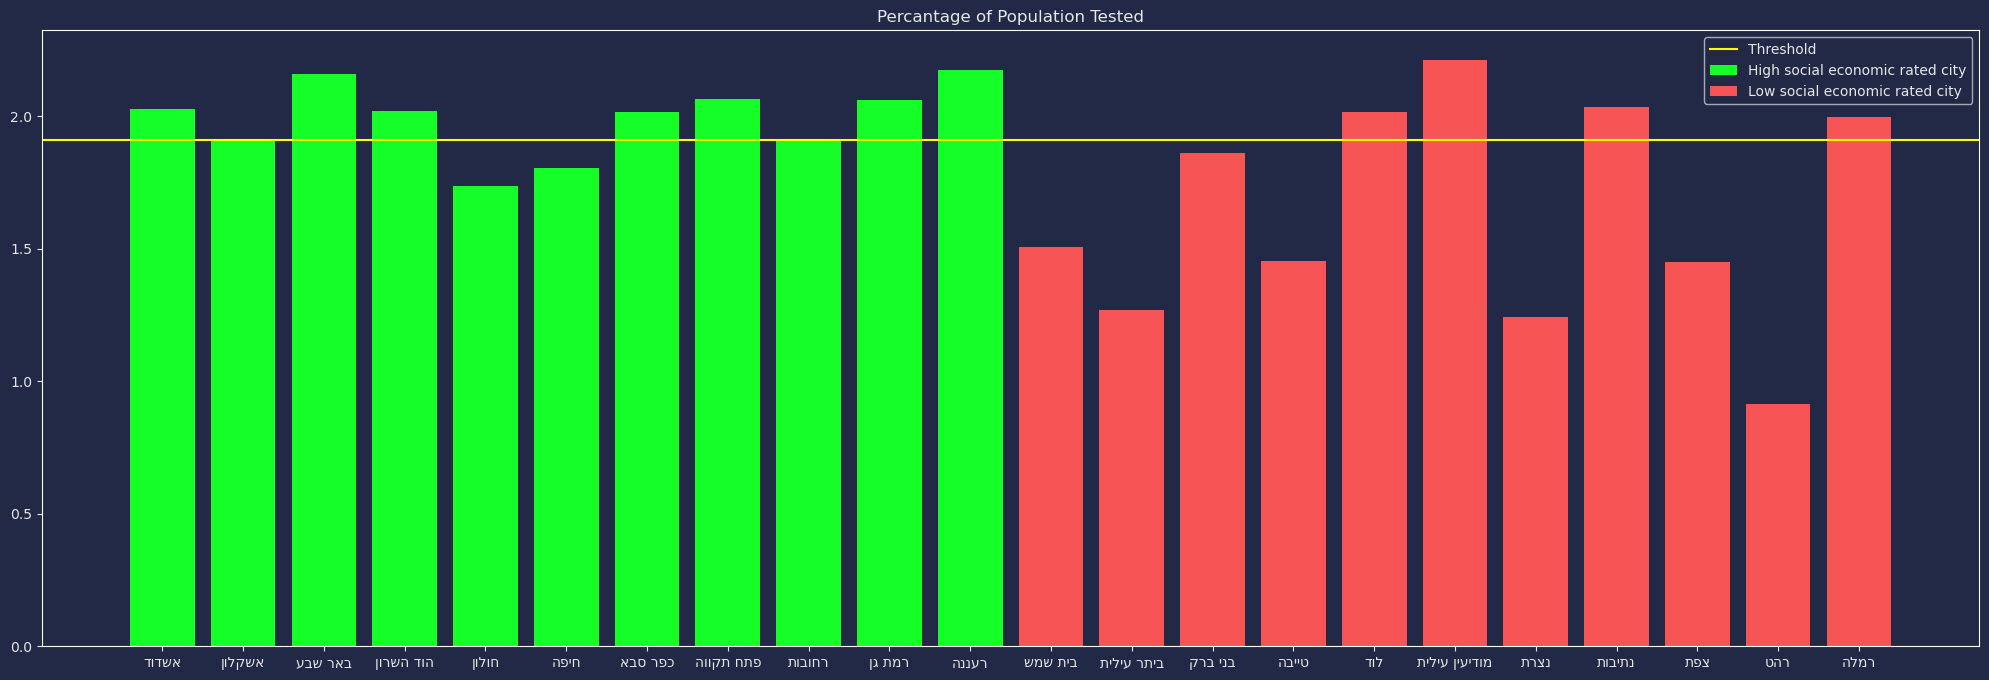

In [30]:
plt.style.use("dark_background")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'
plt.figure(figsize=(25,8))
plt.axhline(1.91, color='#FEFE00', ls='solid', label='Threshold')
plt.bar(CTs[:11],percent_tests[:11] , color = '#15FE27', label='High social economic rated city')
plt.bar(CTs[11:],percent_tests[11:] , color = '#F75555', label='Low social economic rated city')
plt.legend()
plt.title("Percantage of Population Tested")
plt.show()

### We sorted the cities, in green is the high social economic rated cities and in the red is the low one's
### We can see that high social-economic rated cities made more Covid-19 test per person
#### The graph is showing a percent of popultaion that made Covid-19 tests (Total cases / number of population)

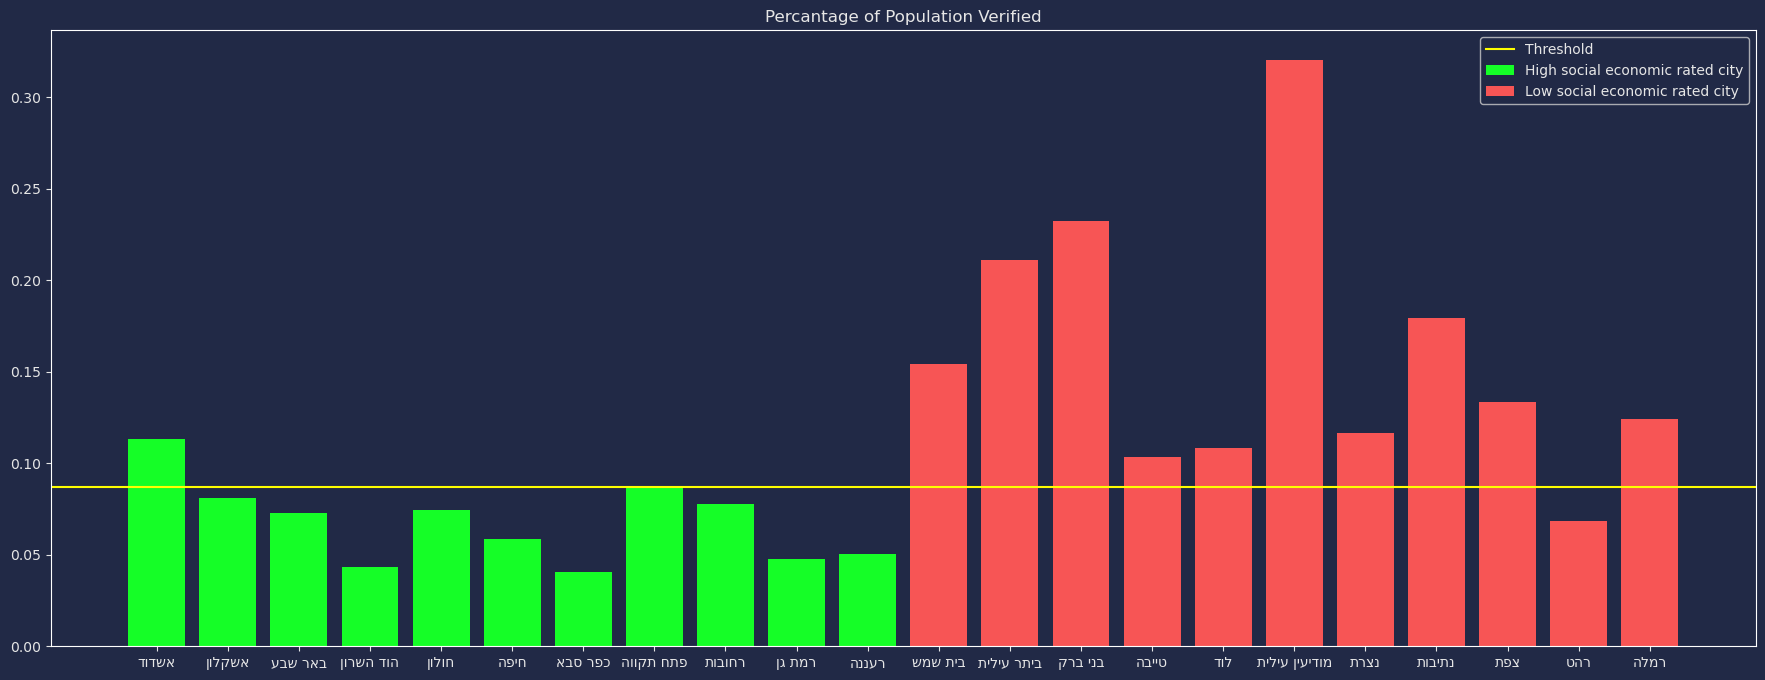

In [31]:
plt.style.use("dark_background")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'
plt.figure(figsize=(22,8))
plt.axhline(0.087, color='#FEFE00', ls='solid', label='Threshold')
plt.bar(CTs[:11],percent_verified[:11] , color = '#15FE27',label='High social economic rated city')
plt.bar(CTs[11:],percent_verified[11:] , color = '#F75555',label='Low social economic rated city')
plt.legend()
plt.title("Percantage of Population Verified")
plt.show()


## We found a threshold of 8.7% that 10/11 of high social-economic rated cities is under the threshold and most of the low social-economic rated cities  10/11 is above the threshold
### That means in low social-economic rated cities was more verified cases
#### The graph is showing a percent of popultaion verified (Total cases / number of population)

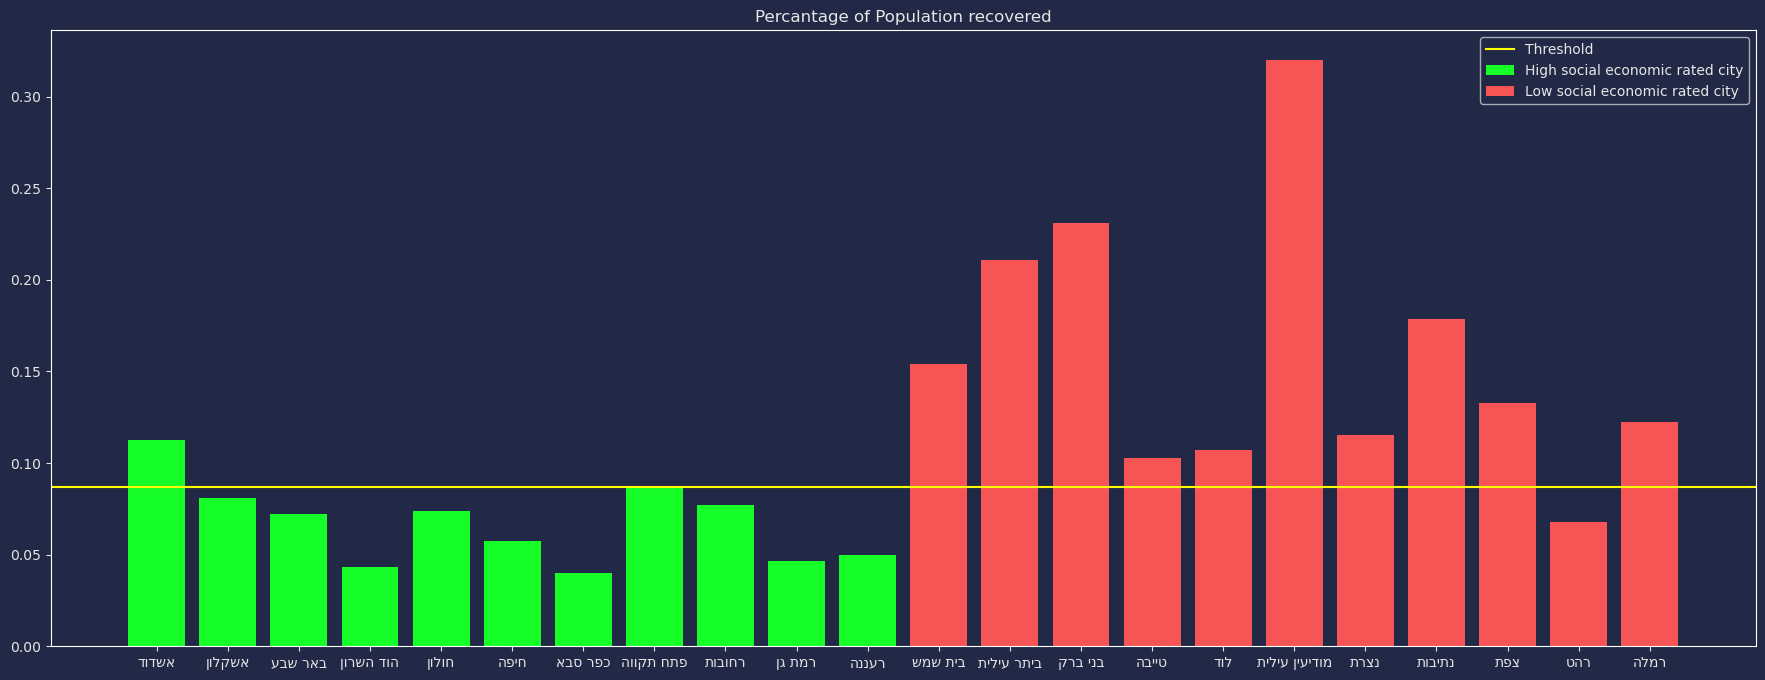

In [32]:
plt.style.use("dark_background")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'
plt.figure(figsize=(22,8))
plt.axhline(0.087, color='#FEFE00', ls='solid', label='Threshold')
plt.bar(CTs[:11], percent_recovered[:11] , color = '#15FE27',label='High social economic rated city')
plt.bar(CTs[11:], percent_recovered[11:] , color = '#F75555',label='Low social economic rated city')
plt.legend()
plt.title("Percantage of Population recovered")
plt.show()

### The graph of recovered people is almost the same as the one above
#### it affects only if people died during the recovery time, so we can see not too much difference between the two graphs 
#### The graph is showing a percent of popultaion recovered (Total cases / number of population)

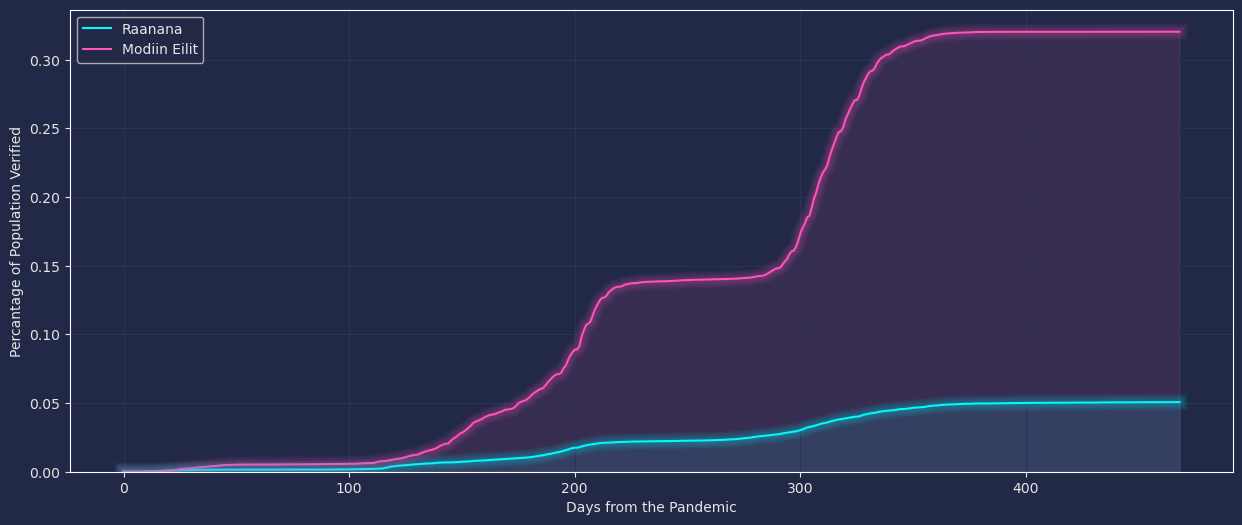

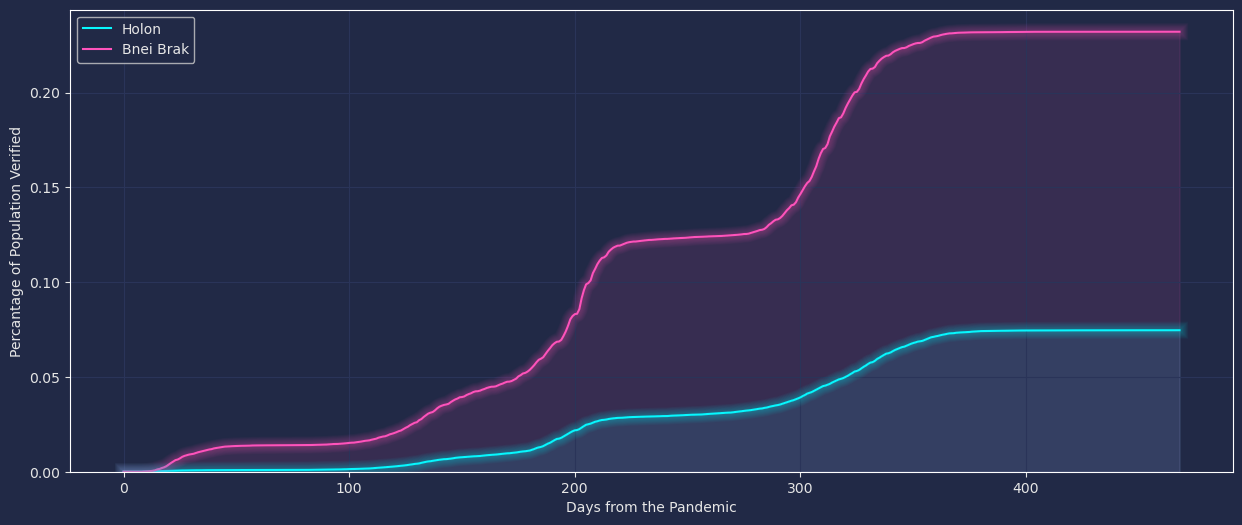

In [33]:
plt.style.use("dark_background")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]

fig, ax = plt.subplots()
df_3.plot( color=colors, ax=ax,figsize=(15,6) )
plt.xlabel('Days from the Pandemic')
plt.ylabel('Percantage of Population Verified')

n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df_3.plot(
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
for column, color in zip(df_3, colors):
    ax.fill_between(x=df_3.index,
                    y1=df_3[column].values,
                    y2=[0] * len(df_3),
                    color=color,
                    alpha=0.1)
ax.grid(color='#2A3459')
ax.set_xlim([ax.get_xlim()[0] - 0.2, ax.get_xlim()[1] + 0.2]) 
ax.set_ylim(0)
fig, ax = plt.subplots()
df_2.plot( color=colors, ax=ax,figsize=(15,6))
plt.xlabel('Days from the Pandemic')
plt.ylabel('Percantage of Population Verified')

n_shades = 10
diff_linewidth = 1.05
alpha_value = 0.3 / n_shades
for n in range(1, n_shades+1):
    df_2.plot(
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value,
            legend=False,
            ax=ax,
            color=colors)
for column, color in zip(df_2, colors):
    ax.fill_between(x=df_2.index,
                    y1=df_2[column].values,
                    y2=[0] * len(df_2),
                    color=color,
                    alpha=0.1)
ax.grid(color='#2A3459')
ax.set_xlim([ax.get_xlim()[0] - 0.2, ax.get_xlim()[1] + 0.2]) 
ax.set_ylim(0)
plt.show()

### It is a comparison between 2 cities that have the same number of population (-,+)
### In the purple is low social economic rated city and in the blue is a high one
#### We can spot the gap between them it's HUGE.

### After we got the data presented by graphs we can see clearly the differences between high social-economicly rated cities and the low one's
### In the 3 first graphs we found  a threshold that divided the high/low social-economic rated cities, in the last 2 graphs we showed the total cases divided by population and we saw that there's a big differnece between high and low social-economic rated cities.
#### Low social-economic cities was affected more from the Covid-19




# 6) Now we will send our dataset to classifiers (Machine learning)
### To find out if by our dataset the machine can predict if the chosen city is high/low          social-economic rated city.
### For that type of prediction we need to use Machine learning classification
### Let's start with Logistic Regression

accuracy is: 0.9168869309838473
precision is: 0.9361702127659575
recall is: 0.8920691711389386
f1 is: 0.9135877862595421


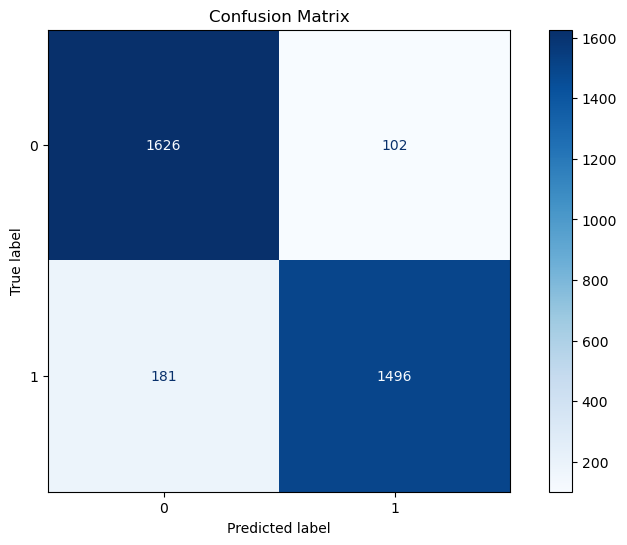

In [34]:
Dont_test =["City Name","Date","Social Economic Rate"]
train = []
for i in df.columns:
    if i not in Dont_test:
        train.append(i)
target ="Social Economic Rate"
X = df[train]
y=df[target]
CLF=[]
ACC=[]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33,random_state=40)
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
LG_model = LogisticRegression().fit(X_train_scaled,y_train)
LG_y_pred = LG_model.predict(X_test_scaled)

print("accuracy is:",metrics.accuracy_score(y_test, LG_y_pred))
print("precision is:",metrics.precision_score(y_test, LG_y_pred))
print("recall is:",metrics.recall_score(y_test, LG_y_pred))
print("f1 is:",metrics.f1_score(y_test, LG_y_pred))
CLF.append("Logistic Regression")
ACC.append(metrics.accuracy_score(y_test, LG_y_pred))
plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))
LG_Matrix = plot_confusion_matrix(LG_model, X_test_scaled, y_test,cmap =plt.cm.Blues, ax=ax) 
LG_Matrix.ax_.set_title("Confusion Matrix")
plt.show()

### So we got an excellent F1 score !
### Our accuracy is 91.5% !


# Let's check other Classifiers...
### Like KNN
#### We will send our parameters to train the model and we have another function that finds the best "K" for us for better prediction

In [35]:
def KNN(X_train, y_train):
    best_k = find_best_K(X_train, y_train)
    params = {'n_neighbors':best_k}
    clf = KNeighborsClassifier(n_neighbors=params['n_neighbors']).fit(X_train, y_train)
    return clf

def find_best_K(X_train, y_train):
    parameters = {'n_neighbors':[x for x in range(3,20,2)]}
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters, scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_K = clf.best_params_['n_neighbors']
    return best_K

accuracy is: 0.9794419970631424
precision is: 0.982003599280144
recall is: 0.9761478831246273
f1 is: 0.9790669856459331


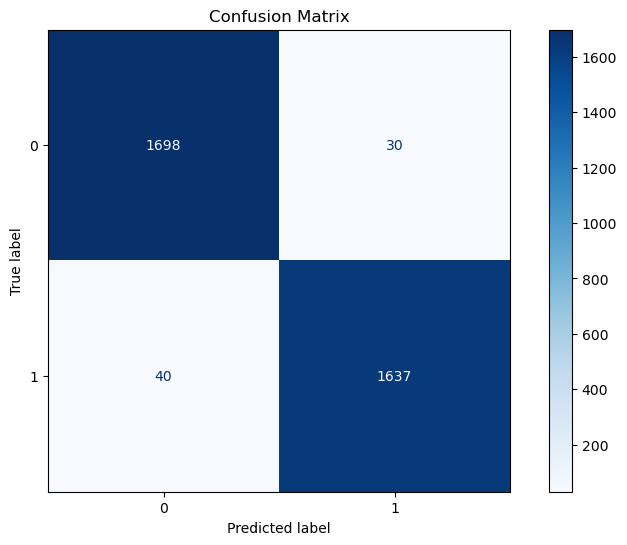

In [36]:

Knn_model = KNN(X_train_scaled,y_train)
Knn_y_pred = Knn_model.predict(X_test_scaled)
print("accuracy is:",metrics.accuracy_score(y_test , Knn_y_pred))
print("precision is:",metrics.precision_score(y_test,Knn_y_pred))
print("recall is:",metrics.recall_score(y_test,Knn_y_pred))
print("f1 is:",metrics.f1_score(y_test, Knn_y_pred))
CLF.append("KNN")
ACC.append(metrics.accuracy_score(y_test , Knn_y_pred))
plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))
KNN_Matrix = plot_confusion_matrix(Knn_model, X_test_scaled, y_test,cmap =plt.cm.Blues, ax=ax) 
KNN_Matrix.ax_.set_title("Confusion Matrix")
plt.show()

### 97% F1 score and the accuracy!
### that's a big difference, for now the KNN worked the best for us

# Now let's Check The Decision Tree
####  We will send again our parameters to train the model and we have to use a function,                                                                       that finds for us the max depth of the tree and the minimum samples split that fits best our model,                                                         and we will send them together to fit the  decision tree model. 

In [37]:
def decision_tree(X_train, y_train):
    best_max_depth, best_min_samples_split = find_best_decision_tree_params(X_train, y_train)
    params = {'max_depth':best_max_depth, 'min_samples_split':best_min_samples_split}
    clf = DecisionTreeClassifier(max_depth=params['max_depth'],min_samples_split=params['min_samples_split']).fit(X_train, y_train)
    return clf    
    
def find_best_decision_tree_params(X_train, y_train):
    parameters = {'max_depth':[2,4,6,8,10], 'min_samples_split':[5,10,15,20]}
    dt = tree.DecisionTreeClassifier()
    clf = GridSearchCV(dt,parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_max_depth = clf.best_params_['max_depth']
    best_min_samples_split = clf.best_params_['min_samples_split']
    return best_max_depth, best_min_samples_split



accuracy is: 0.9994126284875183
precision is: 0.9988088147706968
recall is: 1.0
f1 is: 0.9994040524433849


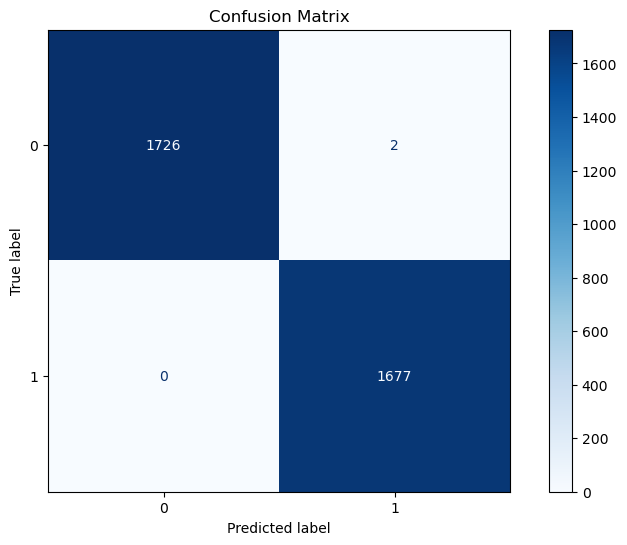

In [38]:

DT_model = decision_tree(X_train_scaled, y_train)
DT_y_pred = DT_model.predict(X_test_scaled)
print("accuracy is:",metrics.accuracy_score(y_test , DT_y_pred))
print("precision is:",metrics.precision_score(y_test,DT_y_pred))
print("recall is:",metrics.recall_score(y_test, DT_y_pred))
print("f1 is:",metrics.f1_score(y_test, DT_y_pred))
CLF.append("Decision Tree")
ACC.append(metrics.accuracy_score(y_test , DT_y_pred))
plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))
DT_Matrix = plot_confusion_matrix(DT_model, X_test_scaled, y_test,cmap =plt.cm.Blues, ax=ax) 
DT_Matrix.ax_.set_title("Confusion Matrix")

plt.show()


##  99.9 % that's almost perfect prediction


In [39]:
Best_Classifiers = pd.DataFrame({"Classifier":CLF , "Accuracy":ACC})
Best_Classifiers

,Classifier,Accuracy
0,Logistic Regression,0.916887
1,KNN,0.979442
2,Decision Tree,0.999413


### As we can see above Decision tree is the best classifier for us with 99.9% accuracy!
### We have a WINNER!


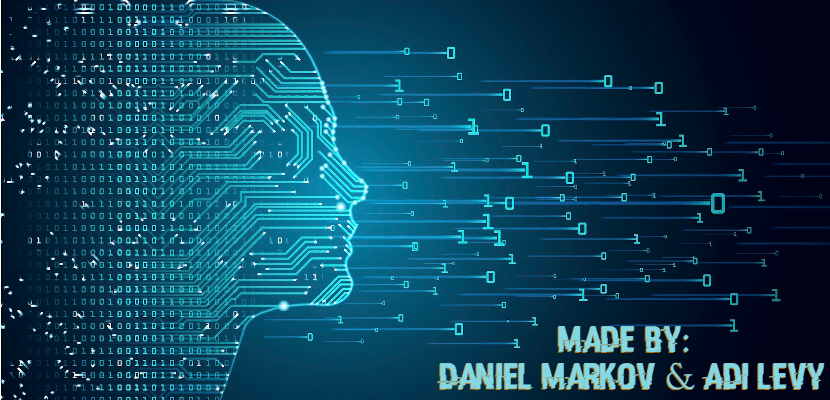

In [40]:
Thank_You



# That's a WOW
## We can predict in 100% which social-economic rate (not 1 & 0) has each city in our dataset!

In [41]:
df.drop(["Social Economic Rate"], axis=1)
df['Social Economic Rate']= Social_Economic

accuracy is: % 100.0


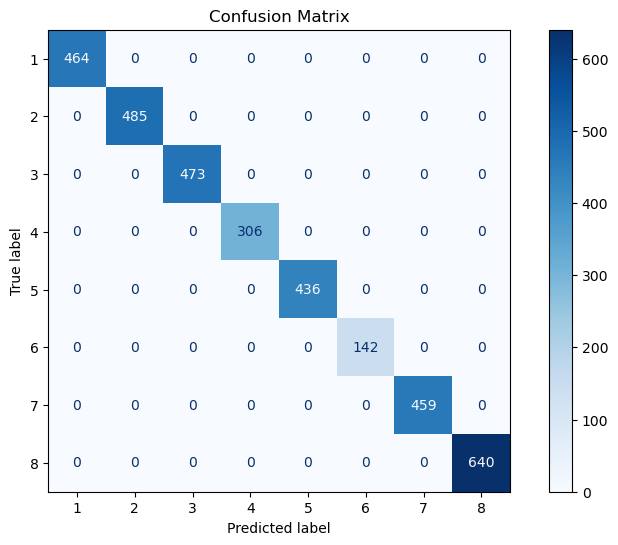

In [42]:

Dont_test =["City Name","Date","Social Economic Rate"]
train = []
for i in df.columns:
    if i not in Dont_test:
        train.append(i)
target ="Social Economic Rate"
X = df[train]
y=df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33,random_state=40)
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
DT_model = decision_tree(X_train_scaled, y_train)
DT_y_pred = DT_model.predict(X_test_scaled)
print("accuracy is: %",(metrics.accuracy_score(y_test , DT_y_pred))*100)
plt.style.use("default")
fig, ax = plt.subplots(figsize=(10, 6))
DT_Matrix = plot_confusion_matrix(DT_model, X_test_scaled, y_test,cmap =plt.cm.Blues, ax=ax) 
DT_Matrix.ax_.set_title("Confusion Matrix")
plt.show()



# WoW #2
### Plotting lively every day the number of new daily verified cases in 2 cities since the Covid-19 started
### One city is low social economic rated and the second one is high
### You can see it only when you run it.

In [43]:
%matplotlib qt

City_1=[]
City_2=[]
plt.style.use("dark_background")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'
plt.figure(figsize=(25,8))     
for i in range(len(Bnei_Brak)):
    plt.legend(['Beit Shemesh','Kfar Saba'])   
    City_1.append(Beit_shemesh[i])
    City_2.append(Kfar_saba[i]) 
    plt.xlim(0,500)
    plt.plot(City_1, color ='#FE53BB' ,marker = '.')
    plt.plot(City_2, color = '#08F7FE', marker = '.')
    plt.title("Beit Shemesh vs Kfar saba")
    plt.xlabel("Days")
    plt.ylabel("Daily Verified")
    plt.pause(0.000000001)
    
plt.show()